1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
2. Recreate the first model (the feature extraction model) with mixed_precision turned on.
 * Does it make the model train faster?
 * Does it effect the accuracy or performance of our model?
 * What's the advantages of using mixed_precision training?

In [1]:
# Import dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip


--2025-07-02 07:42:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   121MB/s    in 15s     

2025-07-02 07:42:58 (103 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [2]:
# Import helper function
!wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-07-02 07:42:58--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2025-07-02 07:42:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-02 07:42:59 (95.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]

FINISHED --2025-07-02 07:42:59--
Total wall clock time: 0.2s
Downloaded: 1 files, 10K in 0s (95.2 MB/s)


In [13]:
from helper_functions import unzip_data,plot_loss_curves,compare_historys

In [4]:
unzip_data("/content/101_food_classes_10_percent.zip")

In [5]:
train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

In [6]:
# Create data inputs
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_datagen = image_dataset_from_directory( train_dir,
                                              label_mode = "categorical",
                                              image_size = (224,224))
test_datagen = image_dataset_from_directory(test_dir,
                                            label_mode = "categorical",
                                            image_size = (224,224),
                                            shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
# Data Augmentation layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_aug_layer = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.20),
    layers.RandomZoom(0.20),
    # layers.Rescaling(1/255.)
])

In [8]:
# Create the model
# 1. Create the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

# 2. Freeze the layers (Non-trainable as it is a feacture extraction model)
base_model.trainable = False

# 3. Create input layer
inputs = layers.Input(shape = (224,224,3),name = "Input_layer")

# 4. Data augmentation layer

x = data_aug_layer(inputs)

# 5. Give inputs to the mode
x = base_model(x,training = False)

# 6. GlobalAveragePool layer
x = layers.GlobalAveragePooling2D(name = "Global_layer")(x)

# 7. Create the output layer
outputs = layers.Dense(101,activation = "softmax",name = "Output_layer")(x)

# Create the model
model_1 = tf.keras.Model(inputs,outputs)

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Compile the model

model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics = ["accuracy"])

# Fit the model

history_1 = model_1.fit(train_datagen,
                        epochs = 10,
                        steps_per_epoch = len(train_datagen),
                        validation_data = test_datagen,
                        validation_steps = int(0.15 * len(test_datagen)))

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 138s 482ms/step - accuracy: 0.1354 - loss: 4.0362 - val_accuracy: 0.4796 - val_loss: 2.4342
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 141s 596ms/step - accuracy: 0.4052 - loss: 2.5777 - val_accuracy: 0.5368 - val_loss: 1.9631
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 597ms/step - accuracy: 0.4665 - loss: 2.2205 - val_accuracy: 0.5524 - val_loss: 1.8028
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.5072 - loss: 2.0158 - val_accuracy: 0.5437 - val_loss: 1.7620
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 322ms/step - accuracy: 0.5259 - loss: 1.8689 - val_accuracy: 0.5694 - val_loss: 1.6576
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - accuracy: 0.5510 - loss: 1.7853 - val_accuracy: 0.5771 - val_loss: 1.6236
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 346ms/step - accuracy: 0.5552 - loss: 1.7297 - val_accuracy: 0.5800 - val_loss: 1.5918
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 65s 275ms/step - accuracy: 0.5779 - los

In [10]:
import numpy as np

# Collect true labels from the test dataset
y_true = np.concatenate([y for x, y in test_datagen], axis=0)

# If your labels are one-hot encoded, you might want to convert them to integer labels
y_true_classes = tf.argmax(y_true, axis=1)

print("Shape of y_true:", y_true.shape)
print("Shape of y_true_classes:", y_true_classes.shape)

Shape of y_true: (25250, 101)
Shape of y_true_classes: (25250,)


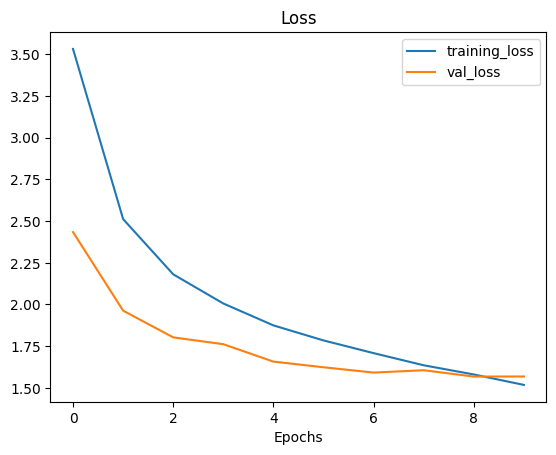

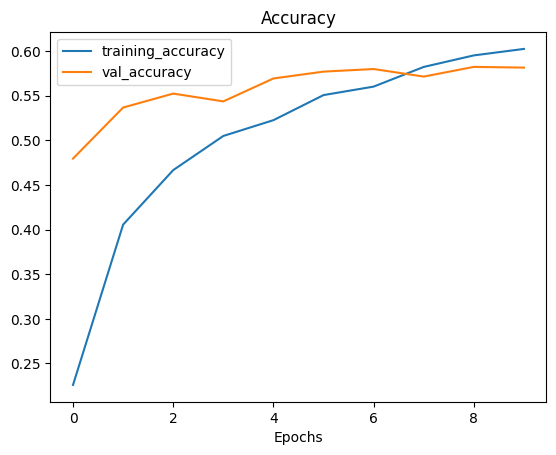

In [14]:
plot_loss_curves(history_1)

In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# 1. Create a model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

# 2. Trainable false
base_model.trainable = False

# 3. Create the inputs
inputs = layers.Input(shape = (224,224,3))

# 4. Create the data augmentation layer
x = data_aug_layer(inputs)

# 5. Put the inputs in base_models
x = base_model(x,training = False)

# 6. GlobalPooling
x = layers.GlobalAveragePooling2D()(x)

# 7. Output layer
outputs = layers.Dense(101,activation = "softmax",dtype = "float32")(x)

# 8. Model time
model_2 = tf.keras.Model(inputs,outputs)

In [27]:
# Compile the model

model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics = ["accuracy"])

# Fit the model

history_01 = model_2.fit( train_datagen,
                          epochs = 5,
                          steps_per_epoch = len(train_datagen),
                          validation_data = test_datagen,
                          validation_steps = int(0.15 * len(test_datagen)),
                        )

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 197s 733ms/step - accuracy: 0.1407 - loss: 4.0499 - val_accuracy: 0.4719 - val_loss: 2.4229
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 201s 741ms/step - accuracy: 0.3969 - loss: 2.6094 - val_accuracy: 0.5199 - val_loss: 1.9893
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.4662 - loss: 2.2093 - val_accuracy: 0.5477 - val_loss: 1.8037
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 432ms/step - accuracy: 0.5107 - loss: 2.0062 - val_accuracy: 0.5577 - val_loss: 1.7359
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 359ms/step - accuracy: 0.5344 - loss: 1.8952 - val_accuracy: 0.5686 - val_loss: 1.6653


In [28]:
# Unfreeze some layers of the model

base_model.trainable = True

# Refreeze all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [29]:
for layer_no,layer in enumerate(base_model.layers):
  print(layer_no,layer,layer.trainable)

0 <InputLayer name=input_layer_5, built=True> False
1 <Rescaling name=rescaling_4, built=True> False
2 <Normalization name=normalization_4, built=True> False
3 <Conv2D name=stem_conv, built=True> False
4 <BatchNormalization name=stem_bn, built=True> False
5 <Activation name=stem_activation, built=True> False
6 <Conv2D name=block1a_project_conv, built=True> False
7 <BatchNormalization name=block1a_project_bn, built=True> False
8 <Activation name=block1a_project_activation, built=True> False
9 <Conv2D name=block1b_project_conv, built=True> False
10 <BatchNormalization name=block1b_project_bn, built=True> False
11 <Activation name=block1b_project_activation, built=True> False
12 <Dropout name=block1b_drop, built=True> False
13 <Add name=block1b_add, built=True> False
14 <Conv2D name=block2a_expand_conv, built=True> False
15 <BatchNormalization name=block2a_expand_bn, built=True> False
16 <Activation name=block2a_expand_activation, built=True> False
17 <Conv2D name=block2a_project_conv, bu

In [30]:
# Recompile model with lower lr (prev - 0.01 now 0.001)
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])

In [31]:
# Re-fit it
history_2 = model_2.fit(train_datagen,
                      epochs = 10,
                      validation_data = test_datagen,
                      validation_steps = int(0.15 * len(test_datagen)),
                      initial_epoch = 5)

Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 105s 349ms/step - accuracy: 0.5008 - loss: 1.9963 - val_accuracy: 0.6025 - val_loss: 1.5133
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.5989 - loss: 1.5611 - val_accuracy: 0.6152 - val_loss: 1.4501
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.6369 - loss: 1.3893 - val_accuracy: 0.6081 - val_loss: 1.5148
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 343ms/step - accuracy: 0.6797 - loss: 1.2259 - val_accuracy: 0.6245 - val_loss: 1.4313
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 348ms/step - accuracy: 0.7061 - loss: 1.1084 - val_accuracy: 0.6168 - val_loss: 1.4509


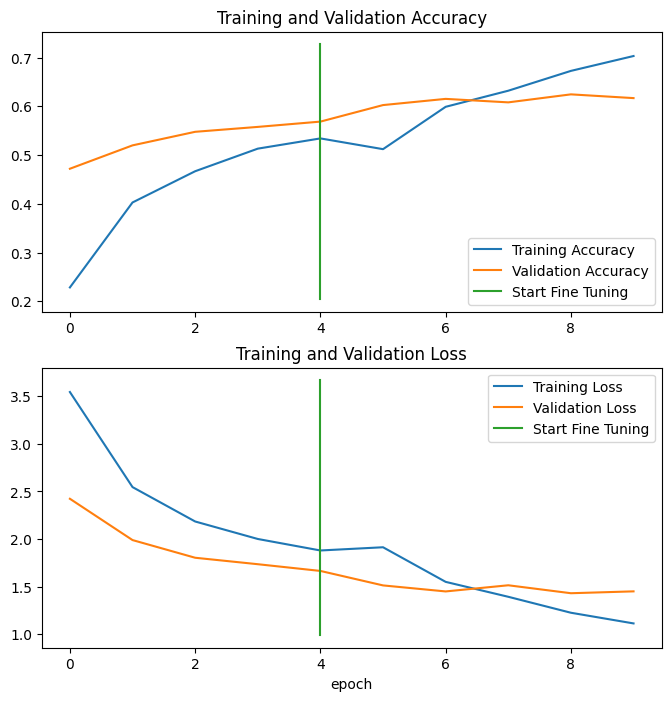

In [32]:
# Compare histories of feauture extraction model with fine tuned model
compare_historys(original_history = history_01,
                 new_history = history_2)

# 2
Check the time taken

In [33]:
# Create the model
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
# 1. Create the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)

# 2. Freeze the layers (Non-trainable as it is a feacture extraction model)
base_model.trainable = False

# 3. Create input layer
inputs = layers.Input(shape = (224,224,3),name = "Input_layer")

# 4. Data augmentation layer

x = data_aug_layer(inputs)

# 5. Give inputs to the mode
x = base_model(x,training = False)

# 6. GlobalAveragePool layer
x = layers.GlobalAveragePooling2D(name = "Global_layer")(x)

# 7. Create the output layer
outputs = layers.Dense(101,activation = "softmax",dtype = "float32",name = "Output_layer")(x)

# Create the model
model_1 = tf.keras.Model(inputs,outputs)

In [34]:
# Compile the model

model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics = ["accuracy"])

# Fit the model

history_1 = model_1.fit(train_datagen,
                        epochs = 10,
                        steps_per_epoch = len(train_datagen),
                        validation_data = test_datagen,
                        validation_steps = int(0.15 * len(test_datagen)))

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 282ms/step - accuracy: 0.1313 - loss: 4.0478 - val_accuracy: 0.4862 - val_loss: 2.3610
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 70s 233ms/step - accuracy: 0.3973 - loss: 2.5926 - val_accuracy: 0.5238 - val_loss: 2.0026
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 58s 243ms/step - accuracy: 0.4671 - loss: 2.2064 - val_accuracy: 0.5506 - val_loss: 1.8106
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy: 0.5039 - loss: 2.0218 - val_accuracy: 0.5471 - val_loss: 1.7461
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 223ms/step - accuracy: 0.5228 - loss: 1.8893 - val_accuracy: 0.5773 - val_loss: 1.6405
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 215ms/step - accuracy: 0.5496 - loss: 1.8026 - val_accuracy: 0.5800 - val_loss: 1.6077
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 215ms/step - accuracy: 0.5685 - loss: 1.7099 - val_accuracy: 0.5757 - val_loss: 1.6224
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 210ms/step - accuracy: 0.5760 - loss: 1

In [35]:
model_1.evaluate(test_datagen)

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.5698 - loss: 1.5937


[1.5462833642959595, 0.5831683278083801]

In [36]:
model_2.evaluate(test_datagen)

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.6216 - loss: 1.4404


[1.3797857761383057, 0.6331881284713745]

# Final - Fine tuned model performed slightly better